# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance # my_measures written by Aaron contains all the methods we need
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack # sparese gets the data into a format that helps us operate on it, this is what helps us remove the 0 values in our logic ops
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, chi2

%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data
(this is where we do our exprimentation for the assignment)

# function that takes raw data and completes all preprocessing required before model fits v1.0
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False) # this is where we make most of our adjustments. 
        # as opposed to CountVectorizer, which gives many many columns, we use hashing vectorizer is a list which removes all the non-zero values of when word doesn't appear in a string
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv) 
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape) # tells us how many words ie., the number of columns
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    # popular words have a larger pull than others and tend to have an influence on prediction, this function prevents that event
    if (not test):
        transformer = TfidfTransformer() # search for class name to learn about its parameters
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False) #normalising the matrix - boolens are 0,1 while integers can be much bigger relatively
        X = sc.fit_transform(X_matrix) #final feature set of bag of words and two quant matrices
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed) #size of test set is 20% of all data
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Version 2.3.2 
**Feature Updates** 
**features remain same but RDG parameters modified**

1. Question mark instead of comma for punc_count
2. binary=True, Word appearance boolean instead of word count
3. Changed random seed to 24

4. ngrams=(2,3)
5. lowercase

6. TfidfTransformer(norm='l2', smooth_idf=False,use_idf=False)
7. Used SelectPercentile feature sklearn.feature_selection.SelectPercentile¶

*Hashvectorizer Syntax*

class sklearn.feature_extraction.text.HashingVectorizer(*, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern='(?u)\b\w\w+\b', ngram_range=(1, 1), analyzer='word', n_features=1048576, binary=False, norm='l2', alternate_sign=True, dtype=<class 'numpy.float64'>)[source]

In [3]:
# function that takes raw data and completes all preprocessing required before model fits v2.3
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, binary=True, alternate_sign=False, ngram_range=(2, 3), lowercase=False) # this is where we make most of our adjustments. 
        # as opposed to CountVectorizer, which gives many many columns, we use hashing vectorizer is a list which removes all the non-zero values of when word doesn't appear in a string
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv) 
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape) # tells us how many words ie., the number of columns
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    # popular words have a larger pull than others and tend to have an influence on prediction, this function prevents that event
    if (not test):
        transformer = TfidfTransformer(norm='l1', smooth_idf=False,use_idf=False) # search for class name to learn about its parameters
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\?")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # SelectPercentile feature selection
    if (not test):
        selector = SelectPercentile(chi2, percentile=10)
        X_selected = selector.fit_transform(X_combined, movie_data['sentiment'])
        fitted_transformations.append(selector)
        print("Shape of X_selected after feature selection:")
        print(X_selected.shape)
    else:
        selector = fitted_transformations[2]
        X_selected_test = selector.transform(X_combined)
        print("Shape of X_selected_test after feature selection:")
        print(X_selected_test.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_selected)
        fitted_transformations.append(sc)
        print("Shape of X after scaling:")
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[3].transform(X_selected_test)
        print("Shape of X_test after scaling:")
        print(X.shape)

    # Create Training and Test Sets
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else:
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): Use any integer apart from 24
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/wasimabbas/Documents/The New School/Spring 24/Machine Learning/Python/ml-master/final_data/moviereviews_train.tsv', my_random_seed=24)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433           2
1         158           0
2         378           0
3         379           1
4         367           1


# Fit (and tune) Various Models
common tip - look at the false negatives

### MODEL: ordinary least squares

In [8]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss='squared_error') # add loss='squared_loss'
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 5032, 'TN': 4822, 'FP': 5186, 'FN': 4960, 'Accuracy': 0.4927, 'Precision': 0.4924642787238207, 'Recall': 0.5036028823058447, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [19]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: SVM, SVC

***svm_1***
C=1.0

# Borrowed from Herson-xyz, Following documentation at: https://scikit-learn.org/stable/auto_examples/svm/plot_svm_margin.html#sphx-glr-auto-examples-svm-plot-svm-margin-py

from sklearn import svm
svm_1 = svm.SVC(C=1.0) # default
svm_1.fit(X_train, y_train)

svm_1_performance_train = BinaryClassificationPerformance(svm_1.predict(X_train), y_train, 'svm_1_train')
svm_1_performance_train.compute_measures()
print(svm_1_performance_train.performance_measures)

***svm_2***
C=100

# Borrowed from Herson-xyz, Following documentation at: https://scikit-learn.org/stable/auto_examples/svm/plot_svm_margin.html#sphx-glr-auto-examples-svm-plot-svm-margin-py

from sklearn import svm
svm_2 = svm.SVC(C=100) # default
svm_2.fit(X_train, y_train)

svm_2_performance_train = BinaryClassificationPerformance(svm_2.predict(X_train), y_train, 'svm_2_train')
svm_2_performance_train.compute_measures()
print(svm_2_performance_train.performance_measures)

***svm_3***
C=0.0001

# Borrowed from Herson-xyz, Following documentation at: https://scikit-learn.org/stable/auto_examples/svm/plot_svm_margin.html#sphx-glr-auto-examples-svm-plot-svm-margin-py

from sklearn import svm
svm_3 = svm.SVC(C=0.0001) # default
svm_3.fit(X_train, y_train)

svm_3_performance_train = BinaryClassificationPerformance(svm_3.predict(X_train), y_train, 'svm_3_train')
svm_3_performance_train.compute_measures()
print(svm_3_performance_train.performance_measures)

***svm_4***
C=0.1

# Borrowed from Herson-xyz, Following documentation at: https://scikit-learn.org/stable/auto_examples/svm/plot_svm_margin.html#sphx-glr-auto-examples-svm-plot-svm-margin-py

from sklearn import svm
svm_4 = svm.SVC(C=0.1) # default
svm_4.fit(X_train, y_train)

svm_4_performance_train = BinaryClassificationPerformance(svm_4.predict(X_train), y_train, 'svm_4_train')
svm_4_performance_train.compute_measures()
print(svm_4_performance_train.performance_measures)

***svm_5***
C=0.5

In [5]:
# Borrowed from Herson-xyz, Following documentation at: https://scikit-learn.org/stable/auto_examples/svm/plot_svm_margin.html#sphx-glr-auto-examples-svm-plot-svm-margin-py

from sklearn import svm
svm_5 = svm.SVC(C=0.5) # default
svm_5.fit(X_train, y_train)

svm_5_performance_train = BinaryClassificationPerformance(svm_5.predict(X_train), y_train, 'svm_5_train')
svm_5_performance_train.compute_measures()
print(svm_5_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9873, 'TN': 9764, 'FP': 244, 'FN': 119, 'Accuracy': 0.98185, 'Precision': 0.9758821785114165, 'Recall': 0.9880904723779024, 'desc': 'svm_5_train'}


### MODEL: logistic regression

In [11]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log_loss') # changed from loss='log'
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9992, 'TN': 10008, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [12]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9613, 'TN': 9436, 'FP': 572, 'FN': 379, 'Accuracy': 0.95245, 'Precision': 0.9438389788905253, 'Recall': 0.9620696557245797, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [13]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9991, 'TN': 10008, 'FP': 0, 'FN': 1, 'Accuracy': 0.99995, 'Precision': 1.0, 'Recall': 0.9998999199359487, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

**Syntax**
class sklearn.linear_model.RidgeClassifier(alpha=1.0, *, fit_intercept=True, copy_X=True, max_iter=None, tol=0.0001, class_weight=None, solver='auto', positive=False, random_state=None)

***rdg_3***
Alpha=10000

In [35]:
from sklearn import linear_model
rdg_3 = linear_model.RidgeClassifier(alpha=10000)
rdg_3.fit(X_train, y_train)

rdg_3_performance_train = BinaryClassificationPerformance(rdg_3.predict(X_train), y_train, 'rdg_3_train')
rdg_3_performance_train.compute_measures()
print(rdg_3_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 9873, 'TN': 9823, 'FP': 185, 'FN': 119, 'Accuracy': 0.9848, 'Precision': 0.9816066812487572, 'Recall': 0.9880904723779024, 'desc': 'rdg_3_train'}


### MODEL: Random Forest Classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 9992, 'Neg': 10008, 'TP': 8388, 'TN': 6214, 'FP': 3794, 'FN': 1604, 'Accuracy': 0.7301, 'Precision': 0.6885568872106387, 'Recall': 0.8394715772618094, 'desc': 'rdf_train'}


### ROC plot to compare performance of SVM variations and NBS

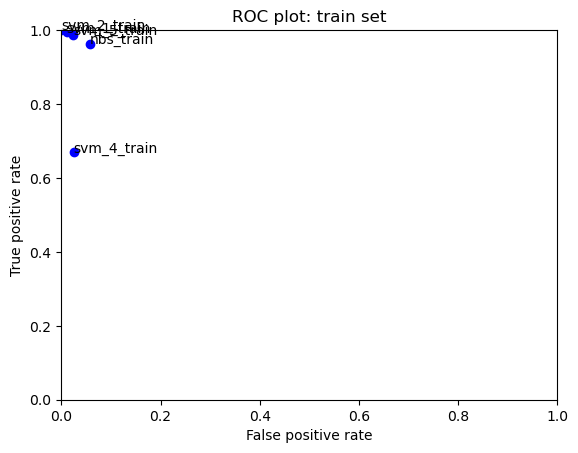

In [44]:
fits = [nbs_performance_train, svm_1_performance_train, svm_2_performance_train, svm_4_performance_train, svm_5_performance_train ]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### ROC plot to compare performance of various models and fits

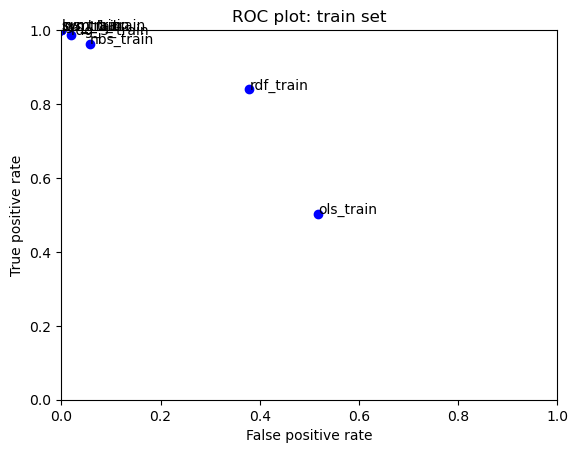

In [21]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_3_performance_train, rdf_performance_train, svm_1_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [13]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [30]:
# false positives

print("Examples of false positives ols:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
108
I enjoy a good, slow-moving drama. Christmas In August, Chungking Express, Virgin Stripped Bare By Her Bachelors, The Way Home, Springtime in a Small Town, Hana bi, Eat Drink Man Woman, Dolls, In the Mood for Love, and Spring Summer Fall Winter Spring are all enjoyable films  just to name a few. <br /><br />Unfortunately, there is a subset of films within the drama genre that attempt to ride the coattails of good films while providing nothing of interest themselves. These are what I call IAN films  \Incomprehensible Artistic Nonsense.\" Tsai Ming-liang is the king of this subgenre, and Vive L'Amour is his \"masterpiece.\" In fact, this is the crème de la crème of crap-infested garbage under the guise of \"art.\" People walk around in their apartments, drink water, stroll back and forth waiting for pay phones to become vacant, hang posters, staple papers together, go to the bathroom, eat, do pushups, have sex, slap at mosquitoes, etc. I'm not joking wh

In [17]:
nbs_predictions = nbs.predict(X_train)

In [18]:
# false positives nbs

print("Examples of false positives nbs:")

import random, time

for i in range(0, len(nbs_predictions)):
    if (nbs_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
71
What was this supposed to be? A remake of Fisher King? Why do we care about Sandler's character? What a slow, dreary, boring, who-gives-a-damn-about-these-people movie!!! Just simply painful to sit through, I turned it off before it was over. It's so obvious that Cheadle needs help as much as Sandler; like I said: can you say \Fisher King\"? And how does this psychotic character function in his daily life? We aren't supposed to think that deeply, I guess. Why does Cheadle continue to give Sandler a chance to turn violent on him? If they were such good friends, how did they grow apart? If Cheadle is so in control, why does he keep seeking the advice of the shrink on the street? We are never told. That's why Fisher King was a better film on so many levels and why this just sucks. Nearly 8 out of 10 average score? I don't agree. At all. Even the top films are lucky to get such a high average rating, and this crap doesn't deserve to be in the same universe w

In [32]:
rdf_predictions = rdf.predict(X_train)

In [34]:
# false positives rfc

print("Examples of false positives rdf:")

import random, time

for i in range(0, len(rdf_predictions)):
    if (rdf_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives rdf:
124
Have you ever heard the saying that people \telegraph their intentions?\" Well in this movie, the characters' actions do more than telegraph future plans -- they show up at your house drunk and buffet you about the head. This could be forgiven if the setting had been used better, or if the characters were more charismatic or nuanced. Embeth Davidtz's character is not mysterious, just wooden, and Kenneth Branagh doesn't succeed in conveying the brash charm his character probably was written to have.<br /><br />The bottom line: obvious plot, one-note performances, unlikeable characters, and grotesque \"Southern\" accents employed by British actors."
* * * * * * * * * 
125
While some performances were good-Victoria Rowell, Adrienne Barbeau, and the two Italian girlfriends come to mind-the story was lame and derivative, the emphasis on the girlfriend's racial background was handled clumsily at best, and the relatives were mostly portrayed as stereotypes

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [17]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 1252, 'TN': 1155, 'FP': 1337, 'FN': 1256, 'Accuracy': 0.4814, 'Precision': 0.4835843955195056, 'Recall': 0.49920255183413076, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [20]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2217, 'TN': 2224, 'FP': 268, 'FN': 291, 'Accuracy': 0.8882, 'Precision': 0.8921529175050302, 'Recall': 0.8839712918660287, 'desc': 'svm_test'}


### MODEL: SVM, SVC

***svm_1***
C=1.0

svm_1_performance_test = BinaryClassificationPerformance(svm_1.predict(X_test), y_test, 'svm_1_test')
svm_1_performance_test.compute_measures()
print(svm_1_performance_test.performance_measures)

***svm_2***
C=100

svm_2_performance_test = BinaryClassificationPerformance(svm_2.predict(X_test), y_test, 'svm_2_test')
svm_2_performance_test.compute_measures()
print(svm_2_performance_test.performance_measures)

***svm_3***
C=0.0001

svm_3_performance_test = BinaryClassificationPerformance(svm_3.predict(X_test), y_test, 'svm_3_test')
svm_3_performance_test.compute_measures()
print(svm_3_performance_test.performance_measures)

***svm_4***
C=0.1

svm_4_performance_test = BinaryClassificationPerformance(svm_4.predict(X_test), y_test, 'svm_4_test')
svm_4_performance_test.compute_measures()
print(svm_4_performance_test.performance_measures)

***svm_5***
C=0.5

In [6]:
svm_5_performance_test = BinaryClassificationPerformance(svm_5.predict(X_test), y_test, 'svm_5_test')
svm_5_performance_test.compute_measures()
print(svm_5_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2340, 'TN': 2209, 'FP': 283, 'FN': 168, 'Accuracy': 0.9098, 'Precision': 0.8921082729698818, 'Recall': 0.9330143540669856, 'desc': 'svm_5_test'}


### MODEL: logistic regression

In [23]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2186, 'TN': 2213, 'FP': 279, 'FN': 322, 'Accuracy': 0.8798, 'Precision': 0.886815415821501, 'Recall': 0.8716108452950558, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [47]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2338, 'TN': 2297, 'FP': 195, 'FN': 170, 'Accuracy': 0.927, 'Precision': 0.9230161863403079, 'Recall': 0.9322169059011164, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [25]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2227, 'TN': 2222, 'FP': 270, 'FN': 281, 'Accuracy': 0.8898, 'Precision': 0.8918702442931518, 'Recall': 0.8879585326953748, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

### rdg_3

In [26]:
rdg_3_performance_test = BinaryClassificationPerformance(rdg_3.predict(X_test), y_test, 'rdg_3_test')
rdg_3_performance_test.compute_measures()
print(rdg_3_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2252, 'TN': 2231, 'FP': 261, 'FN': 256, 'Accuracy': 0.8966, 'Precision': 0.8961400716275368, 'Recall': 0.89792663476874, 'desc': 'rdg_3_test'}


### MODEL: Random Forest Classifier

In [27]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2508, 'Neg': 2492, 'TP': 2089, 'TN': 1552, 'FP': 940, 'FN': 419, 'Accuracy': 0.7282, 'Precision': 0.6896665566193463, 'Recall': 0.8329346092503987, 'desc': 'rdf_test'}


### ROC plot to compare performance SVM variations and NBS

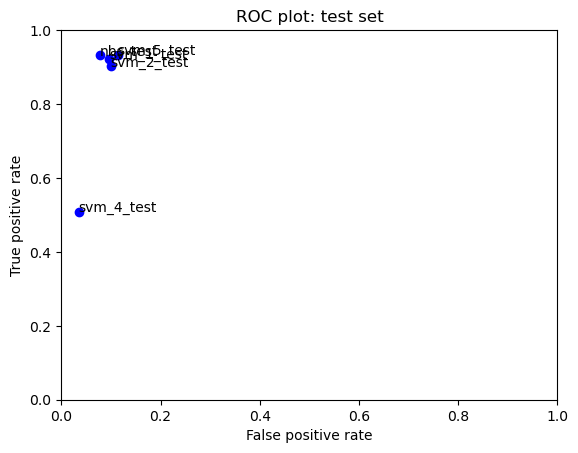

In [48]:
fits = [nbs_performance_test,svm_1_performance_test, svm_2_performance_test, svm_4_performance_test, svm_5_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### ROC plot to compare performance of various models and fits

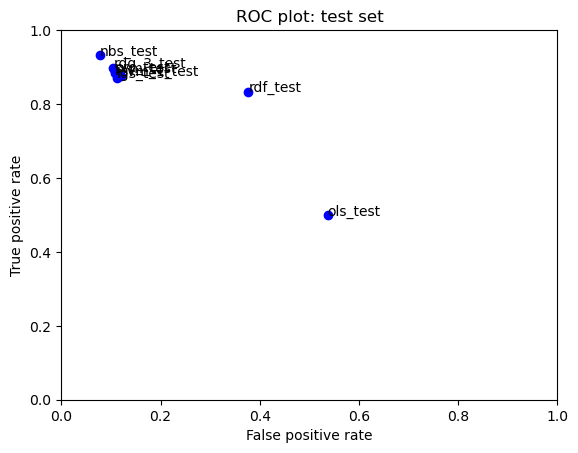

In [28]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_3_performance_test, rdf_performance_test, svm_1_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>
only come here when ready to make a submission

---

In [9]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/Users/wasimabbas/Documents/The New School/Spring 24/Machine Learning/Python/ml-master/final_data/moviereviews_test.tsv', my_random_seed=24, test=True) # make sure the file path is changed, and change random seed to your number
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         131           0
1         169           0
2         176           0
3         112           0
4         133           0
5         331           5
6         121           0
7         230           4
8          59           0
9         224           1
Size

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [10]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = svm_5.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.54644


In [11]:
raw_data.head()

,id,review,word_count,punc_count
0,12311_10,Naturally in a film who's main themes are of m...,131,0
1,8348_2,This movie is a disaster within a disaster fil...,169,0
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,0
3,7186_2,Afraid of the Dark left me with the impression...,112,0
4,12128_7,A very accurate depiction of small time mob li...,133,0


In [12]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,1
4,12128_7,1


In [13]:
my_submission.shape

(25000, 2)

In [14]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/wasimabbas/Documents/The New School/Spring 24/Machine Learning/Python/ml-master/final_assignment_1/my_submissions/moviereviews_submission_svm.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation